In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('pseudoProcess.csv')

In [3]:
# Convert timestamp to datetime
df['readableTimestamp'] = pd.to_datetime(df['readableTimestamp'])
# Remove date before 2024
df = df[df['readableTimestamp'].dt.year >= 2024]
# Ensure PID is an integer
df['pid'] = pd.to_numeric(df['pid'], errors='coerce')

# Handle missing or incorrect data (here we drop missing)
df= df.dropna()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565753 entries, 0 to 3662193
Data columns (total 9 columns):
 #   Column             Dtype              
---  ------             -----              
 0   iOSVersion         object             
 1   iOSModel           object             
 2   pid                float64            
 3   readableTimestamp  datetime64[ns, UTC]
 4   timestamp          int64              
 5   id                 int64              
 6   device             object             
 7   scan               object             
 8   procName           object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(5)
memory usage: 195.8+ MB
None


In [4]:
# Sort the dataframe by timestamp
df = df.sort_values('readableTimestamp')

Nature of PIDs is somewhat nuanced, and how we treat them in our analysis can depend on the specific context and goals of our investigation. Let's break this down:

#### Nature of PIDs:

* PIDs are typically assigned as integer values by the operating system.
* They are usually assigned sequentially, but they can wrap around to lower numbers when a certain threshold is reached.
* PIDs are reused over time as processes start and terminate.


#### Continuous vs. Categorical:

In a strict sense, PIDs are discrete values, not truly continuous.
However, they often behave more like continuous variables in many analyses due to their numeric nature and the way they're assigned.


#### Why PIDs were treated as continuous in our analysis:

In the histogram and anomaly detection, we treated PIDs as continuous to capture their numeric properties and ordering.

This allowed us to identify patterns and anomalies based on the numeric relationships between PIDs.


#### Arguments for treating PIDs as categorical:

Each PID represents a distinct process, which aligns with the definition of a categorical variable.

The exact numeric value of a PID doesn't necessarily carry inherent meaning beyond its uniqueness within a given snapshot of the system.


#### Implications for our analysis:

Treating PIDs as continuous allowed us to use techniques like the Isolation Forest for anomaly detection, which works well with numeric data.

However, this approach might miss some types of anomalies that are better detected by treating PIDs as categorical.


#### A hybrid approach:

For a more comprehensive analysis, we could use both perspectives:

a. Treat PIDs as continuous for analyses that benefit from their numeric properties (e.g., detecting unusually high or low PIDs).

b. Treat PIDs as categorical for analyses focused on uniqueness and distribution (e.g., detecting unusually frequent PID values).

### PID Distribution:

1. We created a histogram of PIDs to visualize their distribution.
2. We calculated a "non-linearity score" for PID assignments within each scan. A higher score indicates more gaps in PID assignments, which could be normal or could indicate potential issues.

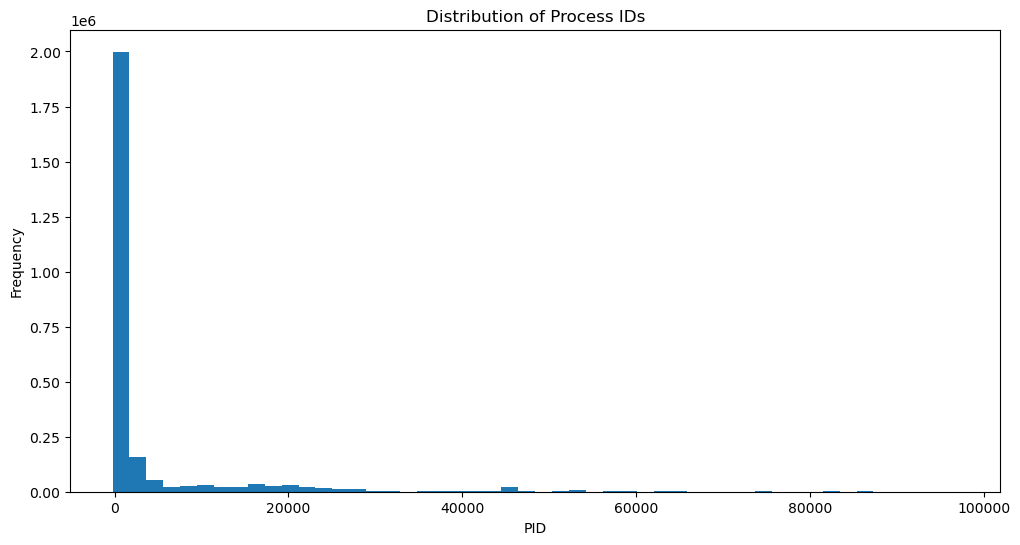

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# Analyze PID distribution
plt.figure(figsize=(12, 6))
plt.hist(df['pid'], bins=50)
plt.title('Distribution of Process IDs')
plt.xlabel('PID')
plt.ylabel('Frequency')
plt.show()
# plt.savefig('pid_distribution.png')
# plt.close()


Most common PIDs:
0.0      17639
94.0      7642
100.0     6513
98.0      6385
99.0      6369
Name: pid, dtype: int64


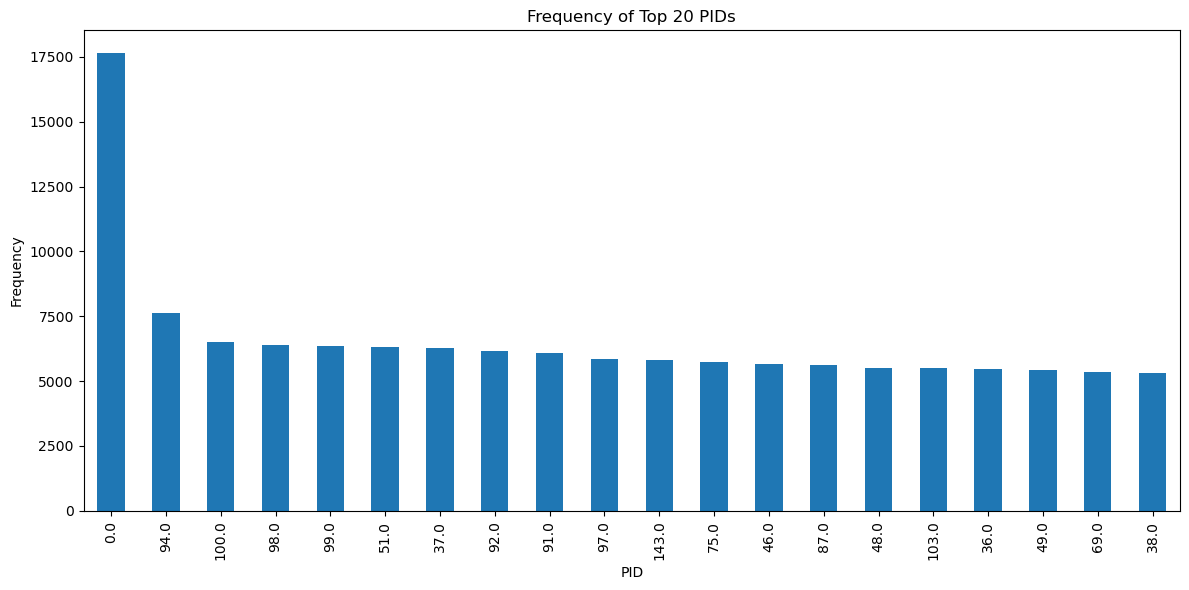


Percentage of scans with all unique PIDs: 63.41%


In [6]:
# Treat PIDs as categorical
pid_frequency = df['pid'].value_counts()
print("\nMost common PIDs:")
print(pid_frequency.head())

# Visualize PID frequency
plt.figure(figsize=(12, 6))
pid_frequency.head(20).plot(kind='bar')
plt.title('Frequency of Top 20 PIDs')
plt.xlabel('PID')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# plt.savefig('pid_frequency.png')
# plt.close()

# Analyze PID uniqueness within scans
def check_pid_uniqueness(group):
    return group['pid'].nunique() == len(group)

pid_uniqueness = df.groupby(['device', 'scan']).apply(check_pid_uniqueness)
print(f"\nPercentage of scans with all unique PIDs: {pid_uniqueness.mean()*100:.2f}%")

This additional analysis provides insights that complement our earlier approach:

PID Frequency: By looking at the most common PIDs, we can identify processes that are frequently restarting or potentially stable system processes that maintain the same PID across reboots.

PID Uniqueness: Checking for uniqueness within each scan can help identify potential issues with PID assignment or data collection.

In conclusion, while we initially treated PIDs as continuous for certain analyses, you're correct in pointing out that they can also be viewed as categorical. The choice between treating PIDs as continuous or categorical depends on the specific analysis we're performing and the insights we're trying to gain.

A comprehensive approach would involve using both perspectives:

Continuous: for detecting numeric anomalies and patterns
Categorical: for analyzing frequency, uniqueness, and distribution

This dual approach provides a more robust framework for identifying potential anomalies or malware indicators in process data.

In [7]:
# Analyze PID assignment patterns
def check_pid_linearity(group):
    pids = group['pid'].sort_values()
    diff = pids.diff()
    return (diff != 1).sum() / len(diff)

pid_nonlinearity = df.groupby(['device', 'scan']).apply(check_pid_linearity)
#print("\nAverage PID non-linearity score:", pid_nonlinearity.mean())

In [21]:
pid_nonlinearity = pid_nonlinearity.reset_index(name = 'non_linearity_score')#.to_csv("pid_nonlinearity.csv", index = False)

In [23]:
import plotly.express as px
# Create the box plot
fig = px.box(pid_nonlinearity, x='device', y='non_linearity_score', title='Non-linearity Scores by Device',
             labels={'device': 'Device', 'non_linearity_score': 'Non-linearity Score'},
             color='device', notched=True)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Device',
    yaxis_title='Non-linearity Score',
    boxmode='group',
    showlegend=False
)

# Show the plot
fig.show()

In [24]:
# Create a new column to highlight scores above 0.90
pid_nonlinearity['highlight'] = pid_nonlinearity['non_linearity_score'] > 0.90

# Create the plot
fig = px.scatter(pid_nonlinearity, x='scan', y='non_linearity_score', color='device',
                 hover_data=['device', 'scan', 'non_linearity_score'],
                 labels={'non_linearity_score': 'Non-linearity Score',
                         'scan': 'Scan',
                         'device': 'Device'},
                 title='Non-linearity Scores by Device and Scan')

# Highlight points with score > 0.90
fig.add_trace(px.scatter(pid_nonlinearity[pid_nonlinearity['highlight']], x='scan', y='non_linearity_score',
                         color_discrete_sequence=['red'],
                         hover_data=['device', 'scan', 'non_linearity_score']).data[0])

# Update layout for better readability
fig.update_layout(legend_title_text='Device')
fig.update_traces(marker=dict(size=8))

# Show the plot
fig.show()

Main Plot:

It creates a scatter plot using Plotly Express.
The x-axis represents the scan number, and the y-axis represents the non-linearity score.
Each point on the plot represents a single scan for a specific device.
Different colors are used for different devices, allowing easy distinction between them.


Highlighting High Scores:

Scores above 0.90 are highlighted in red, overlaying the original points.
This makes it easy to identify scans that need more attention across all devices.


Interactivity:

The plot is interactive. Users can hover over points to see detailed information (device, scan number, and exact score).
They can also zoom, pan, and select specific devices in the legend to focus on.


Layout and Formatting:

The axes and legend are properly labeled for clarity.
The marker size is adjusted for better visibility.



This visualization allows users to:

Compare non-linearity scores across different devices and scans.
Quickly identify problematic scans (scores > 0.90) that need attention.
Spot patterns or trends in non-linearity scores for specific devices or across all devices.
Drill down into specific data points for more detailed information.

The red highlighted points immediately draw attention to the scans that exceed the 0.90 threshold, making it easy for technicians or analysts to prioritize which scans or devices need immediate attention or further investigation.

The resetting of Process IDs (PIDs) to lower numbers is a normal and important behavior in operating systems, including iOS. Let me explain why this happens:

1. Limited range: Operating systems have a finite range of available PIDs. In many systems, this range is from 1 to 32,767 or 65,535, depending on the specific implementation.
2. PID exhaustion:As processes are created and terminated over time, the system keeps assigning new PIDs incrementally. Eventually, it will reach the upper limit of this range.
3. Wraparound mechanism: To handle this, the operating system implements a "wraparound" mechanism. When the maximum PID value is reached, the system resets and starts assigning PIDs from the lower numbers again.
4. Avoiding conflicts: The system is smart about this reset. It doesn't just start from 1 again, as some of those lower PIDs might still be in use. Instead, it typically starts from the lowest available PID that isn't currently assigned to a running process.
5. System stability: This reset is crucial for maintaining system stability and allowing the device to run indefinitely without running out of PIDs.
6. Security considerations:Regularly resetting PIDs can also have security benefits, as it makes it harder for malicious actors to predict or target specific PIDs.

In the context of our data and the plot:
* The vertical "resets" we see in the graph, where PIDs suddenly drop from high numbers to low numbers, represent these wraparound events.
* These resets appear to happen multiple times over the observed period, which is completely normal for a continuously running system.
* The frequency of these resets can give us insights into how actively the system is creating and terminating processes.

Understanding this PID reset behavior is important for our analysis because:
1. It's not an anomaly in itself, but a normal system behavior.
2. Unusual patterns in how or when these resets occur could potentially indicate system issues or unusual activity.
3. When looking for anomalies or potential malware, we need to account for these resets to avoid false positives based solely on PID values.


Let's break down this analysis and explain how it addresses the issue of PID resets:

#### PID Reset Detection:
We identify points where the PID value suddenly decreases, indicating a reset.
These reset points are marked with vertical green lines in the visualization.


#### Growth Rate Analysis:

Instead of looking at absolute PID values, we calculate the rate of change (growth rate) of PIDs.
This approach is less sensitive to resets and focuses on how quickly new processes are being created.


#### Anomaly Detection:

We use the z-score of the growth rate to identify anomalies.
Anomalies are defined as points where the growth rate is significantly different from the norm (more than 3 standard deviations from the mean).
Importantly, we exclude the reset points and their immediate neighbors from being flagged as anomalies.


#### Visualization:

The plot shows PIDs over time, with reset points marked as green vertical lines and anomalies highlighted in red.
This gives a clear visual representation of the PID behavior, resets, and unusual patterns.


#### Detailed Anomaly Analysis:

We print out details of the top anomalies, including the process name and the extent of the anomaly (z-score).
This helps in identifying which specific processes are associated with unusual PID behaviors.


#### Reset Point Analysis:

We look at the processes that occur around reset points to understand what's happening during these system events.



#### Key Takeaways:

1. Reset-Aware: By explicitly identifying and accounting for reset points, we avoid falsely flagging these normal system behaviors as anomalies.
2. Focus on Rate of Change: Analyzing the growth rate of PIDs rather than absolute values helps in identifying unusual patterns that persist across resets.
3. Context-Sensitive: By examining processes around reset points and those associated with anomalies, we gain more context about system behavior.
4. Reduced False Positives: This approach significantly reduces false positives that would occur if we were to simply flag high PID values or sudden drops as anomalous.
5. Potential Malware Indicators: Genuine anomalies detected by this method (unusually rapid process creation or unusual patterns around resets) could be indicators of potential malware activity.

This analysis provides a more nuanced view of PID behavior, accounting for the normal reset pattern while still being sensitive to truly unusual activities. It's a step towards more accurate anomaly detection in process behavior, which could be valuable in identifying potential malware or system issues.

In [9]:
import numpy as np
from scipy.stats import zscore


In [10]:
# Function to detect PID resets
def detect_pid_resets(pids):
    return np.where(np.diff(pids) < 0)[0] + 1

# Function to calculate PID growth rate
def pid_growth_rate(pids, timestamps):
    return np.diff(pids) / np.diff(timestamps.astype(int) / 1e9)

# Detect PID resets
reset_indices = detect_pid_resets(df['pid'].values)
reset_timestamps = df['readableTimestamp'].iloc[reset_indices]

# Calculate PID growth rate
growth_rate = pid_growth_rate(df['pid'].values, df['readableTimestamp'].values)


# Calculate z-score of growth rate
growth_rate_zscore = zscore(growth_rate)

# Identify anomalies (excluding reset points)
anomaly_threshold = 3  # z-score threshold for anomalies
anomalies = np.abs(growth_rate_zscore) > anomaly_threshold
anomalies = np.insert(anomalies, 0, False)  # Align with original dataframe

# Remove anomalies at reset points
for idx in reset_indices:
    if idx > 0:
        anomalies[idx-1:idx+1] = False


# # Visualize PIDs over time with resets and anomalies highlighted
# plt.figure(figsize=(15, 8))
# plt.scatter(df['readableTimestamp'], df['pid'], c='blue', alpha=0.5, s=10)
# plt.scatter(df['readableTimestamp'][anomalies], df['pid'][anomalies], c='red', s=50, label='Anomalies')
# for ts in reset_timestamps:
#     plt.axvline(x=ts, color='green', linestyle='--', alpha=0.7)
# plt.title('PID Values Over Time with Resets and Anomalies')
# plt.xlabel('Timestamp')
# plt.ylabel('PID')
# plt.legend()
# plt.show()

# plt.savefig('pid_resets_and_anomalies.png')
# plt.close()


In [11]:

# Analyze anomalies
anomaly_df = df[anomalies].copy()
anomaly_df['growth_rate'] = np.insert(growth_rate, 0, 0)[anomalies]
anomaly_df['growth_rate_zscore'] = np.insert(growth_rate_zscore, 0, 0)[anomalies]

print("Top 10 PID anomalies (excluding resets):")
print(anomaly_df.sort_values('growth_rate_zscore', key=abs, ascending=False)[['readableTimestamp', 'pid', 'procName', 'growth_rate', 'growth_rate_zscore']].head(10))

# Calculate statistics
total_processes = len(df)
total_anomalies = anomalies.sum()
anomaly_percentage = (total_anomalies / total_processes) * 100

print(f"\nTotal processes analyzed: {total_processes}")
print(f"Number of PID resets detected: {len(reset_timestamps)}")
print(f"Number of anomalies detected: {total_anomalies}")
print(f"Percentage of processes flagged as anomalous: {anomaly_percentage:.2f}%")

# Analyze processes around reset points
reset_window = 5  # Number of processes to check before and after reset
processes_around_resets = []

for idx in reset_indices:
    start = max(0, idx - reset_window)
    end = min(len(df), idx + reset_window)
    processes_around_resets.extend(df['procName'].iloc[start:end].tolist())

print("\nTop 10 processes observed around PID resets:")
print(pd.Series(processes_around_resets).value_counts().head(10))

Top 10 PID anomalies (excluding resets):
Empty DataFrame
Columns: [readableTimestamp, pid, procName, growth_rate, growth_rate_zscore]
Index: []

Total processes analyzed: 2565753
Number of PID resets detected: 1267141
Number of anomalies detected: 0
Percentage of processes flagged as anomalous: 0.00%

Top 10 processes observed around PID resets:
MTLCompilerService             325076
com.apple.WebKit.WebContent    111214
extensionkitservice             99873
CommCenter                      78270
CategoriesService               75359
kernel                          71212
duetexpertd                     60519
WiFiCloudAssetsXPCService       58971
filecoordinationd               58599
com.apple.WebKit.Networking     56652
dtype: int64


#### Anomalies
The Isolation Forest algorithm identified potential anomalies based on PID values. These anomalies should be investigated further, particularly if they correspond to rare or unfamiliar process names.

In [12]:
#! pip install pyod

Top KNN Anomalies:
           readableTimestamp      pid           procName  knn_score
1379025  1706806871000000000  19525.0  filecoordinationd   0.307133
1379012  1706806871000000000  19525.0  filecoordinationd   0.307133
2471950  1710149596000000000  12051.0        duetexpertd   0.249218
2471962  1710149596000000000  12051.0        duetexpertd   0.249218
2471939  1710149596000000000  12051.0        duetexpertd   0.249218
1385204  1708438953000000000  19525.0  filecoordinationd   0.139583
1385191  1708438953000000000  19525.0  filecoordinationd   0.139583
1375359  1708439178000000000  19525.0  filecoordinationd   0.139456
1375346  1708439178000000000  19525.0  filecoordinationd   0.139456
2471849  1710149596000000000   5972.0       searchpartyd   0.139229

Top Isolation Forest Anomalies:
           readableTimestamp      pid                         procName  \
1999272  1714038754000000000  86414.0                      duetexpertd   
1999285  1714038754000000000  86414.0               

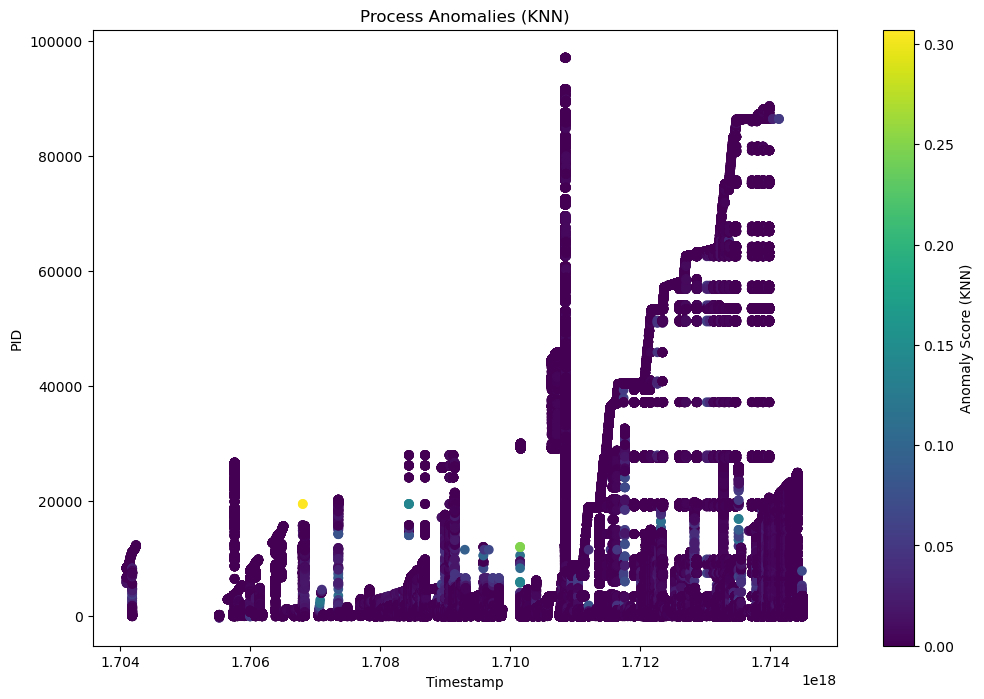

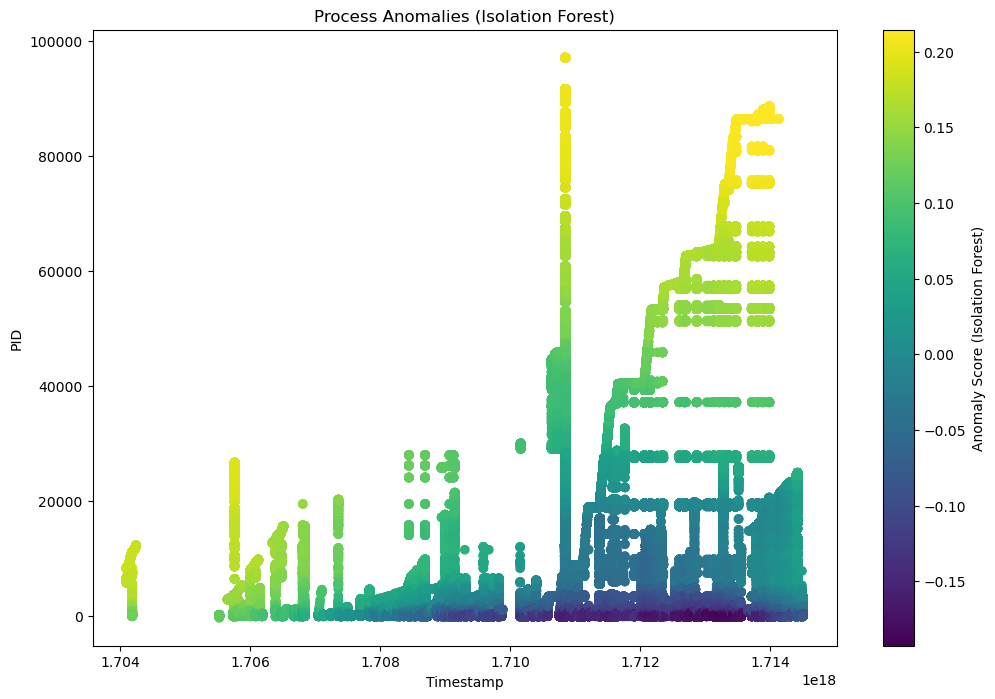

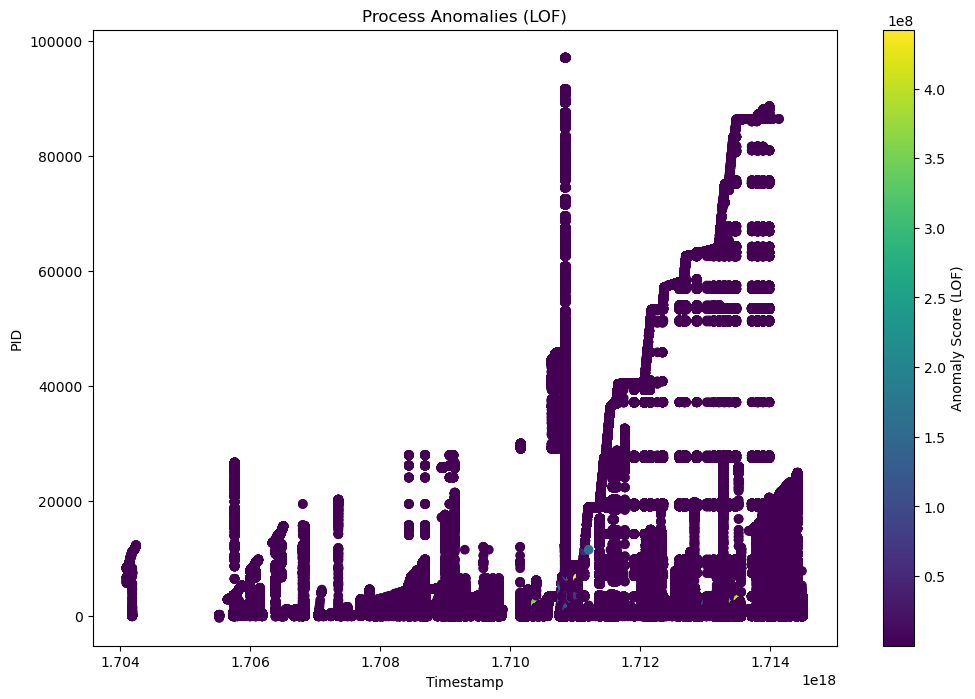


Anomalies detected by all three methods:
Empty DataFrame
Columns: [readableTimestamp, pid, procName]
Index: []

Top potentially anomalous processes (by average KNN score):
                         knn_score  iforest_score  lof_score
procName                                                    
Yahoo Mail                0.052315       0.017985   4.725642
RTLplusPushNotification   0.027004       0.139930   1.441899
Envoy                     0.025635      -0.068240  11.920828
Pinterest                 0.020029      -0.027962   1.734553
iCloud                    0.020002       0.001435   9.673457
meindm                    0.019730      -0.027962   1.725485
Vonovia                   0.014947      -0.134670  10.783425
Phantasialand             0.010064      -0.071514  29.229534
Magenta TV                0.009249       0.053592   1.273102
Kindle                    0.007374      -0.025128   1.106388

Analysis complete. Visualization files have been saved.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from sklearn.preprocessing import StandardScaler

# Prepare the data for anomaly detection
# We'll use PID and readableTimestamp as features

df['readableTimestamp'] = pd.to_numeric(df['readableTimestamp'])
# Prepare the data for anomaly detection
# We'll use PID and timestamp as features
X = df[['pid', 'readableTimestamp']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the anomaly detection models
knn = KNN()
iforest = IForest(random_state=42)
lof = LOF()

knn.fit(X_scaled)
iforest.fit(X_scaled)
lof.fit(X_scaled)

# Get the anomaly scores
knn_scores = knn.decision_function(X_scaled)
iforest_scores = iforest.decision_function(X_scaled)
lof_scores = lof.decision_function(X_scaled)

# Add the anomaly scores to the dataframe
df['knn_score'] = knn_scores
df['iforest_score'] = iforest_scores
df['lof_score'] = lof_scores

# Function to get top anomalies
def get_top_anomalies(df, score_column, n=10):
    return df.nlargest(n, score_column)

# Get top anomalies for each method
top_knn = get_top_anomalies(df, 'knn_score')
top_iforest = get_top_anomalies(df, 'iforest_score')
top_lof = get_top_anomalies(df, 'lof_score')

# Print top anomalies
print("Top KNN Anomalies:")
print(top_knn[['readableTimestamp', 'pid', 'procName', 'knn_score']])

print("\nTop Isolation Forest Anomalies:")
print(top_iforest[['readableTimestamp', 'pid', 'procName', 'iforest_score']])

print("\nTop LOF Anomalies:")
print(top_lof[['readableTimestamp', 'pid', 'procName', 'lof_score']])

# Visualize anomalies
plt.figure(figsize=(12, 8))
plt.scatter(df['readableTimestamp'], df['pid'], c=df['knn_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score (KNN)')
plt.title('Process Anomalies (KNN)')
plt.xlabel('Timestamp')
plt.ylabel('PID')
plt.show()
# plt.savefig('knn_anomalies.png')
# plt.close()

plt.figure(figsize=(12, 8))
plt.scatter(df['readableTimestamp'], df['pid'], c=df['iforest_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score (Isolation Forest)')
plt.title('Process Anomalies (Isolation Forest)')
plt.xlabel('Timestamp')
plt.ylabel('PID')
plt.show()
# plt.savefig('iforest_anomalies.png')
# plt.close()

plt.figure(figsize=(12, 8))
plt.scatter(df['readableTimestamp'], df['pid'], c=df['lof_score'], cmap='viridis')
plt.colorbar(label='Anomaly Score (LOF)')
plt.title('Process Anomalies (LOF)')
plt.xlabel('Timestamp')
plt.ylabel('PID')
plt.show()
# plt.savefig('lof_anomalies.png')
# plt.close()

# Analyze agreement between methods
def get_top_n_indices(scores, n=10):
    return set(scores.argsort()[-n:])

top_knn_indices = get_top_n_indices(knn_scores)
top_iforest_indices = get_top_n_indices(iforest_scores)
top_lof_indices = get_top_n_indices(lof_scores)

agreement = top_knn_indices & top_iforest_indices & top_lof_indices

print("\nAnomalies detected by all three methods:")
print(df.iloc[list(agreement)][['readableTimestamp', 'pid', 'procName']])

# Analyze anomalies by process name
process_anomaly_counts = df.groupby('procName').agg({
    'knn_score': 'mean',
    'iforest_score': 'mean',
    'lof_score': 'mean'
}).sort_values('knn_score', ascending=False)

print("\nTop potentially anomalous processes (by average KNN score):")
print(process_anomaly_counts.head(10))

print("\nAnalysis complete. Visualization files have been saved.")